In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from FoodSeg103_data_handler import *

c:\Users\roman\anaconda3\envs\ilastik2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create scribbles

Load the ground truths as batch

In [12]:
img_nums = [856]#[n for n in range(0, 4900, 80)] #[1382] #2750 #1234 #2314
gts = load_food_batch(img_nums, load_images=False)[1]
num_imgs = len(gts)
print(f"Total images: {num_imgs}")

Total images: 1


Check and filter for resolution

In [13]:
resol = {im_num: np.prod(gt.shape) for im_num, gt in gts.items()}

# Check for images with resolution over a certain threshold
thresh = 250_000
print("Resolutions:")
for im_num, r in resol.items(): print(f"{im_num:4d}: {r:9,d} pixels{' (!)' if r > thresh else ''}")

Resolutions:
 856:    65,536 pixels


In [14]:
# Filter out those images
gts = {im_num: gt for im_num, gt in gts.items() if resol[im_num] <= thresh}
num_imgs = len(gts)
print(f"Images with resolution under {thresh:,d}: {num_imgs}")
resol_new = {im_num: np.prod(gt.shape) for im_num, gt in gts.items()}
for im_num, r in resol_new.items(): print(f"{im_num:4d}: {r:7,d} pixels")

Images with resolution under 250,000: 1
 856:  65,536 pixels


Define scribbles parameters

In [5]:
# Which scribbles to create
bins = [0.25]#[0.25, 1, 5]
scribble_width = 3
suff = ["TEST"] #["w3"] #standing for width 3
rel_scribble_len = 10
scribble_width = 3
scribbles_seed = 1

# Where to save the scribbles
folder_path = "./FoodSeg103_results/data/food_run02"

save_res = False
show_res = True
print_steps = True

Loop and create scribbles

In [24]:
percentages = {}
for bin in bins:
    percentages[bin] = []
    for img_num, gt in gts.items():
        for s in suff:
            np.random.seed(scribbles_seed)
            print(f"IMG {img_num}: bin {bin}, suff {s}")
            scribbles, perc_labelled = create_food_scribble(gt, folder_path, img_num, bin=bin, margin=0.75, rel_scribble_len=rel_scribble_len, mode="all",
                                                            save_res=save_res, suff=s, show_res=show_res, image=None, print_steps=print_steps, scribble_width=scribble_width)
            percentages[bin].append(perc_labelled)
            print(f"Annotation percentage: {perc_labelled:2.2f}%\n")

IMG 856: bin 0.25, suff TEST
CLASS 1:
   sk_max_pix: 24.06, sq_size: 25, sq_pix_range: (36, 150)
         Adjusting square size and range to 12 (18, 150)
         sk_max_pix_left: 24.061666666666664
         Adjusting square size and range to 6 (9, 150)
         sk_max_pix_left: 24.061666666666664
      prim_sk_squares pix: 18 = 0.06%
         Adjusting square size and range to 12 (18, 150)
         sk_max_pix_left: 24.061666666666664
         Adjusting square size and range to 6 (9, 150)
         sk_max_pix_left: 24.061666666666664
      sec_sk_squares pix: 18 = 0.06%
   lines_max_pix: 24.06, line_pix_range: (36, 150)
         Adjusting line range to (18, 300)
         lines_max_pix_left: 24.061666666666664
      lines pix: 20 = 0.07%
   Chceking for pixels OUTSIDE the class ground truth (all scribbles types together) - before: 56 = 0.19%
      0 pixel(s) removed from the scribble because they were outside the ground truth mask (probably due to dilation to scribble width).
      Coord

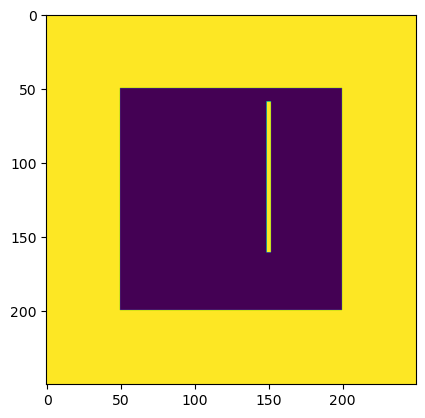

In [17]:
from skimage.morphology import *
gt_mask = np.zeros((250, 250))
gt_mask[50:200, 50:200] = 1
sk = np.zeros((250, 250))
sk[60:160, 150] = 1
sk = binary_dilation(sk, square(3))
from matplotlib import pyplot as plt
from scribbles_creator import create_lines_optim
lines = create_lines_optim(sk, gt_mask, lines_max_pix=20, lines_margin=0.75, line_pix_range=(10, 40), scribble_width=2, init_line_crop=0, print_steps=True)
plt.imshow(np.logical_or(gt_mask==0, sk*200))
plt.show()


In [ ]:
print(lines[45:65, 102:112])

Quick report of labelling percentages:

In [ ]:
for bin, perc_list in percentages.items():
    print(f"labelled percentage in bin {bin}: mean = {np.mean(perc_list):.4f}, std = {np.std(perc_list):.4f}, range = {np.min(perc_list):.4f} - {np.max(perc_list):.4f}")

Check percentages of saved scribbles

In [ ]:
perc_dict = {}
for bin in bins:
    bin_perc_list = []
    for img_num in range(0,540,20):
        for s in suff:
            scrib = np.array(Image.open(f"{folder_path}{img_num:03d}_scribbles_{mode}_{bin_for_file(bin)}_{s}.png"))
            perc_labelled = np.sum(scrib > 0) / scrib.size
            bin_perc_list.append(perc_labelled)
    perc_dict[bin] = bin_perc_list

Show the last created scribble with its ground truth, and all ground truths (optionally)

In [ ]:
v = napari.Viewer()
v.add_labels(gt, name="Ground Truth")
v.add_labels(scribbles, name="Scribbles")

In [ ]:
for g in gts:
    v.add_labels(gts[g], name=f"GT {g}")